In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as pyplot
import seaborn as sb

Prepare data

DateTimeParse переводить стрічку вигляду 'year-month-day h:m:s' в Series з індексами: 'year', 'month', 'day','hour', 'minute', 'second'

In [50]:
def DateTimeParse(date):
    parsed  =datetime.strptime(date, '%Y-%m-%d %H:%M:%S');
    year = parsed.year;
    month = parsed.month;
    day = parsed.day;
    hours = parsed.hour;
    minutes = parsed.minute;
    seconds = parsed.second;
    return pd.Series(data =[year,month,day,hours,minutes,seconds],index = ['year', 'month', 'day','hour', 'minute', 'second']);

In [51]:
df = pd.read_csv('train.csv');

In [52]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Треба відфільтрувати аномальні дані такі як 3.52e+06 секунд,1 секунда.

In [54]:
min_trip_duration = 60*5; # дві хвилини
max_trip_duration = 60*60*24 #одна доба
df =df[(df['trip_duration'] <= max_trip_duration ) &  (df['trip_duration'] >= min_trip_duration)];

In [55]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.238155e+06,1.238155e+06,1.238155e+06,1.238155e+06,1.238155e+06,1.238155e+06,1.238155e+06
mean,1.536051e+00,1.670977e+00,-7.397303e+01,4.074987e+01,-7.397304e+01,4.075078e+01,1.086177e+03
std,4.986988e-01,1.316048e+00,7.565315e-02,3.361450e-02,7.523984e-02,3.697737e-02,3.424871e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,3.000000e+02
25%,1.000000e+00,1.000000e+00,-7.399215e+01,4.073627e+01,-7.399145e+01,4.073421e+01,5.100000e+02
50%,2.000000e+00,1.000000e+00,-7.398202e+01,4.075303e+01,-7.397997e+01,4.075364e+01,7.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396808e+01,4.076733e+01,-7.396316e+01,4.076851e+01,1.173000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,8.639200e+04


Приведення дати і часу до зі стрічки до числових параметрів

In [56]:
date_times = df['pickup_datetime'];
to_insert =date_times.apply(DateTimeParse);

In [57]:
insert = pd.DataFrame(np.array(to_insert),index=df.index,columns = ['year', 'month', 'day','hour', 'minute', 'second']);

In [58]:
df[['year', 'month', 'day','hour', 'minute', 'second']] = insert

In [59]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hour,minute,second
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17,24,55
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,0,43,35
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11,35,24
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19,32,31
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13,30,55


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1238155 entries, 0 to 1458642
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1238155 non-null  object 
 1   vendor_id           1238155 non-null  int64  
 2   pickup_datetime     1238155 non-null  object 
 3   dropoff_datetime    1238155 non-null  object 
 4   passenger_count     1238155 non-null  int64  
 5   pickup_longitude    1238155 non-null  float64
 6   pickup_latitude     1238155 non-null  float64
 7   dropoff_longitude   1238155 non-null  float64
 8   dropoff_latitude    1238155 non-null  float64
 9   store_and_fwd_flag  1238155 non-null  object 
 10  trip_duration       1238155 non-null  int64  
 11  year                1238155 non-null  int64  
 12  month               1238155 non-null  int64  
 13  day                 1238155 non-null  int64  
 14  hour                1238155 non-null  int64  
 15  minute         

In [61]:
df.to_csv(r'.\train_fixed.csv',index = False)

In [64]:
df =pd.read_csv('train_fixed.csv')

Analysis

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236098 entries, 0 to 1458642
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1236098 non-null  object 
 1   vendor_id           1236098 non-null  int64  
 2   pickup_datetime     1236098 non-null  object 
 3   dropoff_datetime    1236098 non-null  object 
 4   passenger_count     1236098 non-null  int64  
 5   pickup_longitude    1236098 non-null  float64
 6   pickup_latitude     1236098 non-null  float64
 7   dropoff_longitude   1236098 non-null  float64
 8   dropoff_latitude    1236098 non-null  float64
 9   store_and_fwd_flag  1236098 non-null  object 
 10  trip_duration       1236098 non-null  int64  
 11  year                1236098 non-null  int64  
 12  month               1236098 non-null  int64  
 13  day                 1236098 non-null  int64  
 14  hour                1236098 non-null  int64  
 15  minute         

In [14]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,year,month,day,hour,minute,second
count,1.236098e+06,1.236098e+06,1.236098e+06,1.236098e+06,1.236098e+06,1.236098e+06,1.236098e+06,1236098.0,1.236098e+06,1.236098e+06,1.236098e+06,1.236098e+06,1.236098e+06
mean,1.535282e+00,1.670298e+00,-7.397303e+01,4.074988e+01,-7.397304e+01,4.075078e+01,9.502475e+02,2016.0,3.530464e+00,1.552955e+01,1.370282e+01,2.954794e+01,2.947048e+01
std,4.987538e-01,1.315317e+00,7.568196e-02,3.360725e-02,7.528224e-02,3.697674e-02,6.585746e+02,0.0,1.681242e+00,8.701858e+00,6.349968e+00,1.730504e+01,1.732297e+01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,3.000000e+02,2016.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399215e+01,4.073628e+01,-7.399145e+01,4.073421e+01,5.090000e+02,2016.0,2.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01,1.400000e+01
50%,2.000000e+00,1.000000e+00,-7.398202e+01,4.075303e+01,-7.397997e+01,4.075364e+01,7.610000e+02,2016.0,4.000000e+00,1.500000e+01,1.400000e+01,3.000000e+01,2.900000e+01
75%,2.000000e+00,2.000000e+00,-7.396808e+01,4.076733e+01,-7.396317e+01,4.076851e+01,1.170000e+03,2016.0,5.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,4.400000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,2.141100e+04,2016.0,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01


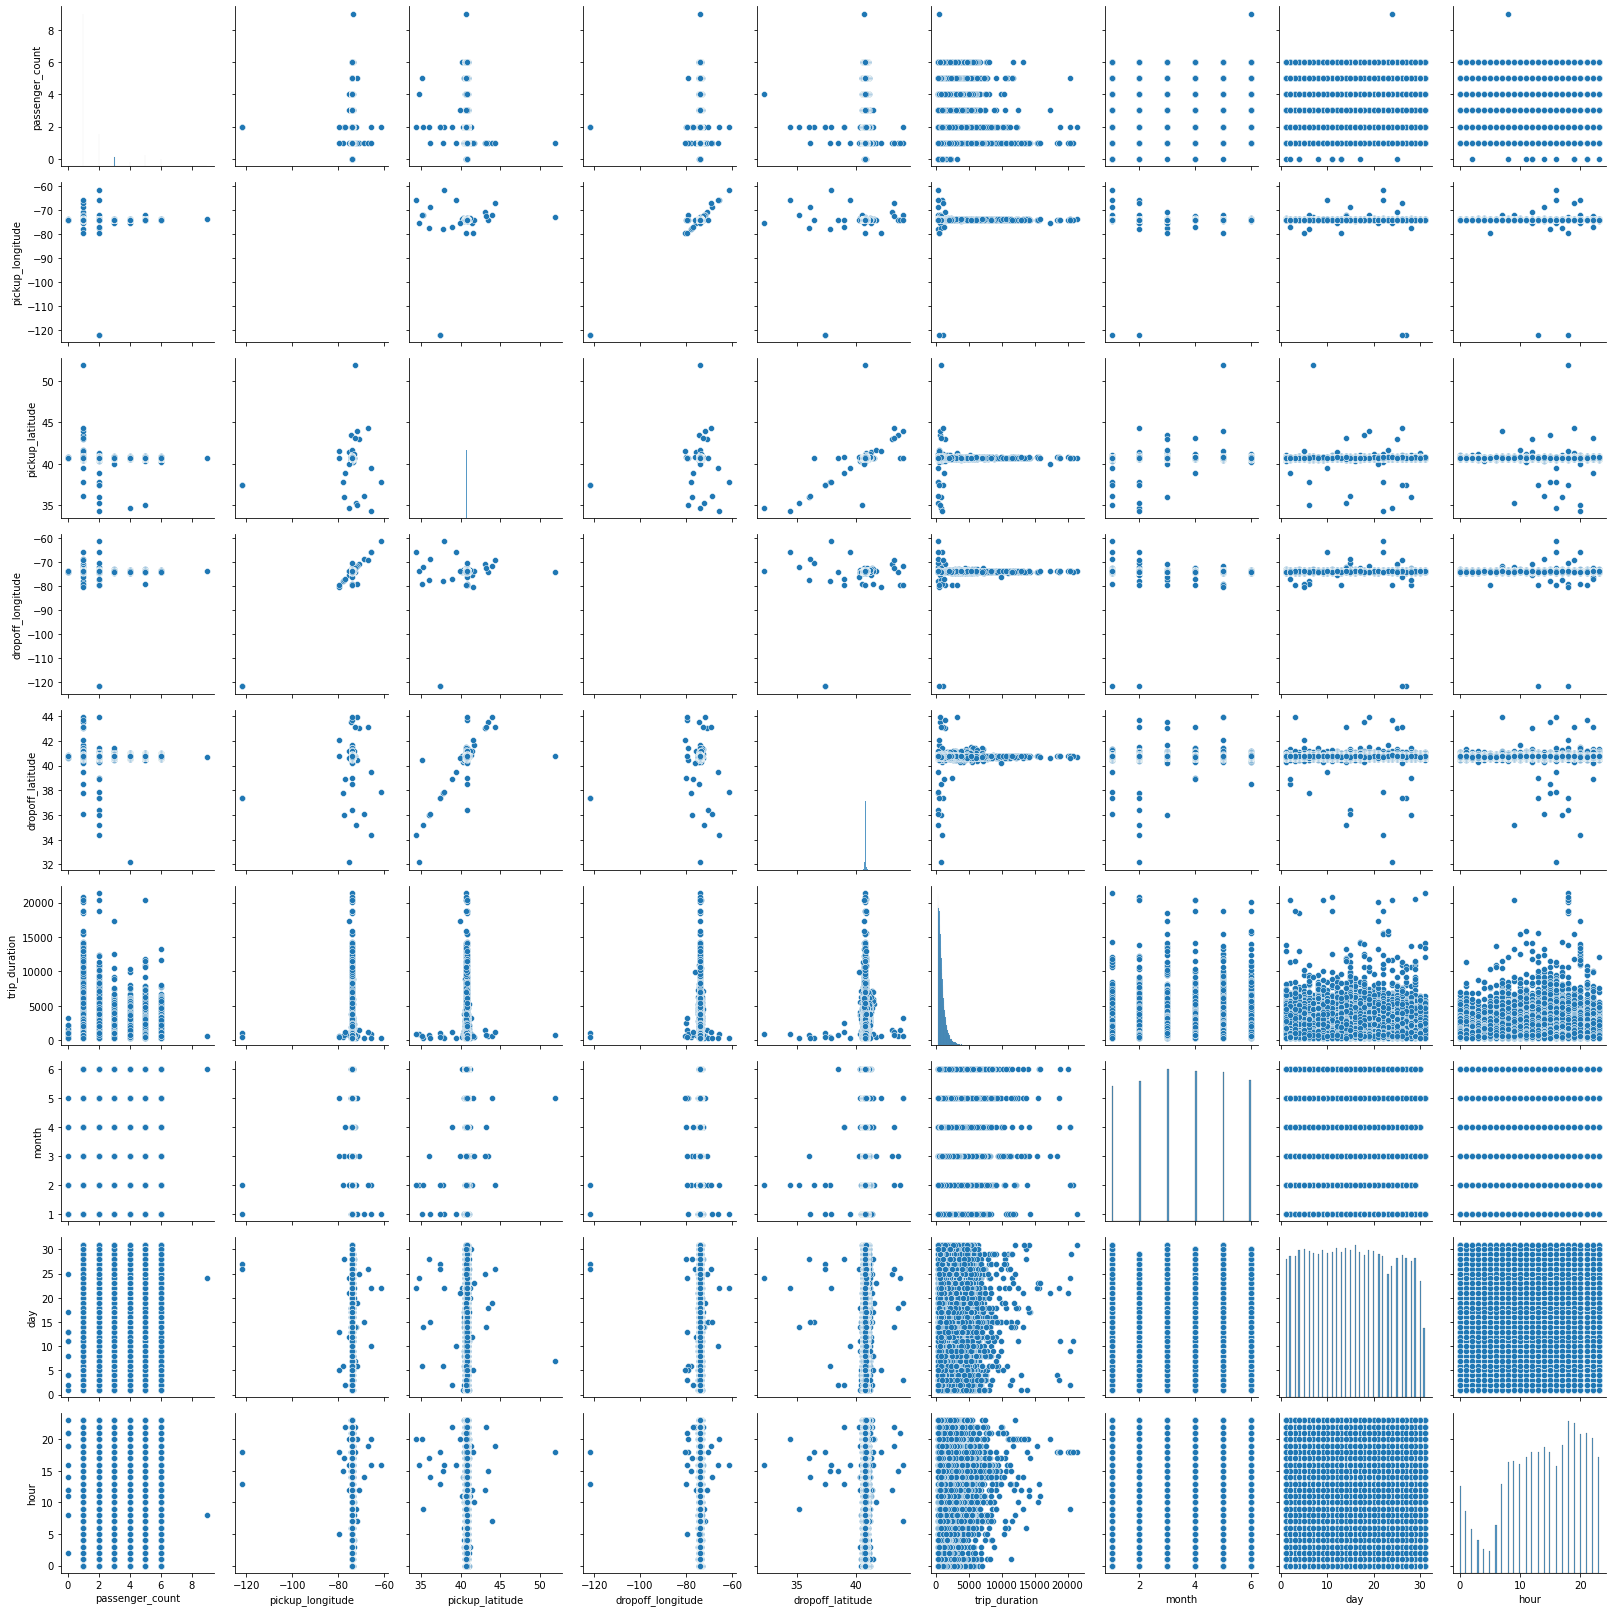

In [15]:
columns = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration', 'month', 'day','hour']

sb.pairplot(df[columns]);
pyplot.tight_layout();
pyplot.show()

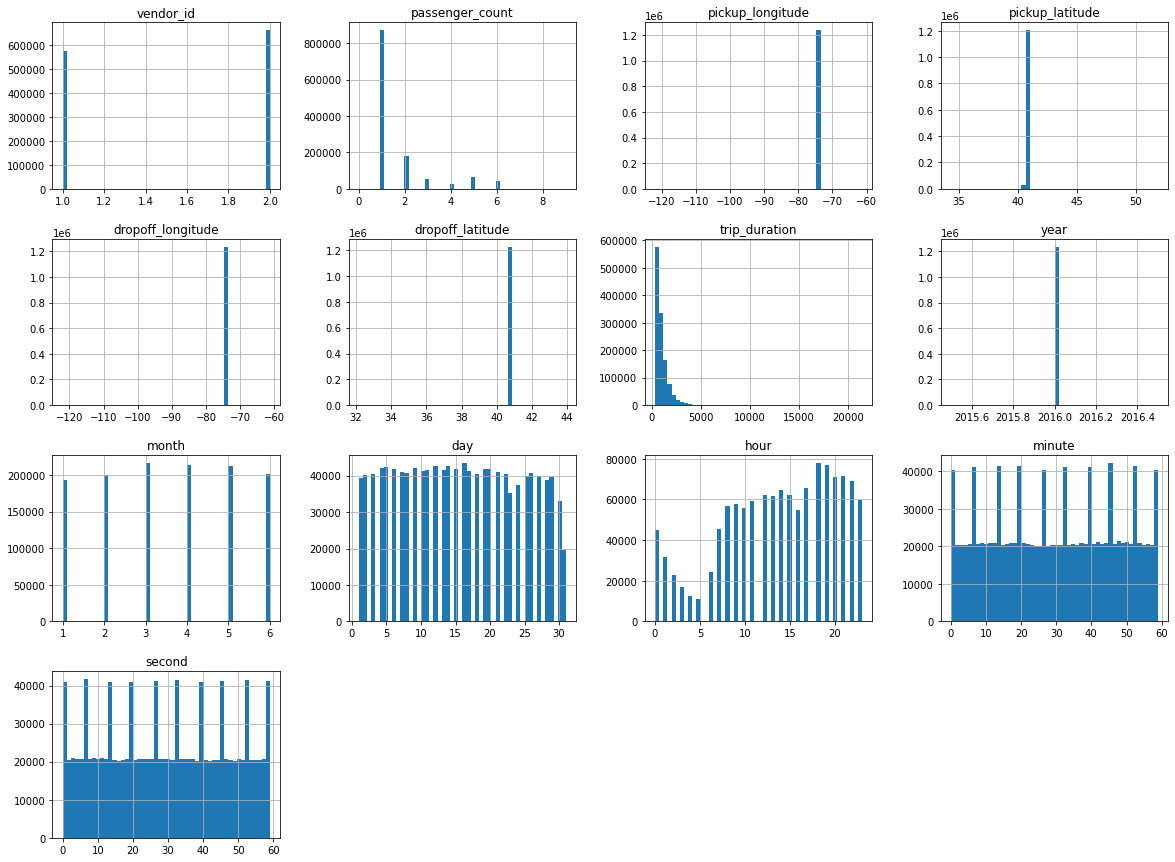

In [16]:
df.hist(bins = 50,figsize = (20,15))
pyplot.show()

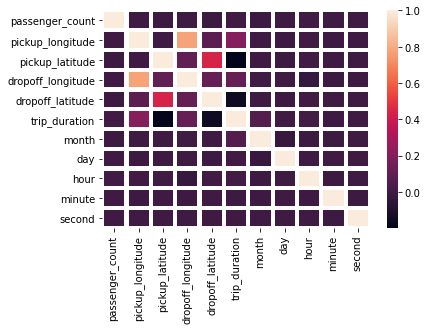

In [17]:
columns = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration', 'month', 'day','hour', 'minute', 'second']
cm = df[columns].corr()

hm = sb.heatmap(data =cm,cbar = True,annot = False,square = False,xticklabels =columns,yticklabels = columns,linewidths = 3.2)

pyplot.show()


In [18]:
corr_matrix = df.corr()
corr_matrix['trip_duration'].sort_values(ascending = False)

trip_duration        1.000000
pickup_longitude     0.208412
dropoff_longitude    0.120686
month                0.061008
hour                 0.017488
passenger_count      0.011747
day                  0.010363
vendor_id            0.007912
second              -0.000302
minute              -0.009937
dropoff_latitude    -0.153943
pickup_latitude     -0.197228
year                      NaN
Name: trip_duration, dtype: float64

Modify Data

In [19]:
#df.drop(['id','pickup_datetime','dropoff_datetime','vendor_id','store_and_fwd_flag','year','second','minute'],axis=1,inplace=True);

In [65]:
df['distance'] =np.sqrt((df.pickup_longitude - df.dropoff_longitude)**2+(df.pickup_latitude - df.dropoff_latitude)**2)*1000

In [66]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hour,minute,second,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17,24,55,17.679539
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,0,43,35,20.455904
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11,35,24,59.933799
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19,32,31,13.438206
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13,30,55,10.689569


In [67]:
df.drop(['id','pickup_datetime','dropoff_datetime','store_and_fwd_flag','year','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','minute','second'],axis=1,inplace=True);

Training

In [68]:
X, y =df.drop(['trip_duration'],axis=1,inplace=False),df['trip_duration'];

In [70]:
X

,vendor_id,passenger_count,month,day,hour,distance
0,2,1,3,14,17,17.679539
1,1,1,6,12,0,20.455904
2,2,1,1,19,11,59.933799
3,2,1,4,6,19,13.438206
4,2,1,3,26,13,10.689569
...,...,...,...,...,...,...
1238150,2,5,2,2,0,20.842519
1238151,2,4,4,8,13,13.791401
1238152,1,1,1,10,7,57.997754
1238153,2,1,4,22,6,76.326934


In [71]:
y

0           455
1           663
2          2124
3           429
4           435
           ... 
1238150     414
1238151     778
1238152     655
1238153     764
1238154     373
Name: trip_duration, Length: 1238155, dtype: int64

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.4, random_state=42)

In [120]:
polinomial_degree = 2;

In [121]:
polynomial_features = PolynomialFeatures(degree=polinomial_degree,
                                         include_bias=False);
linear_regression = LinearRegression(normalize=True);

pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomial_features', PolynomialFeatures(include_bias=False)),
                ('linear_regression', LinearRegression(normalize=True))])

In [122]:
predicted = pipeline.predict(X_test);

In [123]:
predicted

array([1969.08886719,  944.06933594,  897.87353516, ...,  581.96459961,
        745.06079102,  900.69750977])

In [124]:
np.array(y_test.values)

array([1370,  475,  445, ...,  326,  483,  586], dtype=int64)

In [125]:
mean_squared_error(y_test.values,predicted)

11526325.417794796

In [126]:
mean_absolute_error(y_test.values,predicted)

482.80268345177774

In [127]:
delta = abs(y_test.values -predicted)

In [128]:
min(predicted)

202.08251953125

In [129]:
max(predicted)

27455.32568359375

In [130]:
min(delta)

0.001708984375